In [15]:
import numpy as np
from hsa_hopper.kinematics import KinematicParameters, forward_kinematics
from hsa_hopper.hsa_model import HSAPotential
import hsa_hopper.dynamics
from scipy.optimize import root_scalar
import yaml

# load hsa potential
with open('../data/hsa_identification/hsa_model.yaml','r') as f:
    potential_attributes = yaml.load(f,yaml.Loader)
potential = HSAPotential.make_from_dict(potential_attributes)
psi = 90

# coming up with a y coordinate mapping to test this strategy
L1 = .07
L2 = .15
kin_params = KinematicParameters(L1,L2,.3,-.005)
thetaN = theta_lo = -28*np.pi/180
dynamics_params = hsa_hopper.dynamics.DynamicsParameters(
    m=1.3,
    J=4e-3,
    bx=9e-2,
    by=0.,
    # Kx=1.,
    Kx = 0,
    x0=theta_lo,
    kinematics=kin_params,
    hsa_potential=potential,
    # hsa_potential=None,
    psi=psi
)
tf = .12

# solve for equilibrium angle
theta1 = root_scalar(
    lambda theta: hsa_hopper.dynamics.evaluate(theta,0,0,dynamics_params),
    bracket=(20*np.pi/180,-45*np.pi/180)
    ).root



# now for some boundary conditions
y = lambda x: forward_kinematics(kin_params,x)[0]
dy = lambda x: forward_kinematics(kin_params,x,jacobian=True)[1][0]
d2y = lambda x: forward_kinematics(kin_params,x,jacian=True,hessian=True)[2][0]

y1 = y(theta1)
yN = y(thetaN)
print(y1)
print(yN)
ydot1 = 0
ydotN = 1.

thetadot1 = root_scalar(lambda thetadot: dy(theta1)*thetadot-ydot1, bracket=(-20,20)).root
thetadotN = root_scalar(lambda thetadot: dy(thetaN)*thetadot-ydotN, bracket=(-20,20)).root
print(theta1,thetadot1)
print(thetaN,thetadotN)

0.15881180200450282
0.16953772317373833
-0.34987158190790046 0.0
-0.4886921905584123 -13.043341338060001


0.15881180200450304


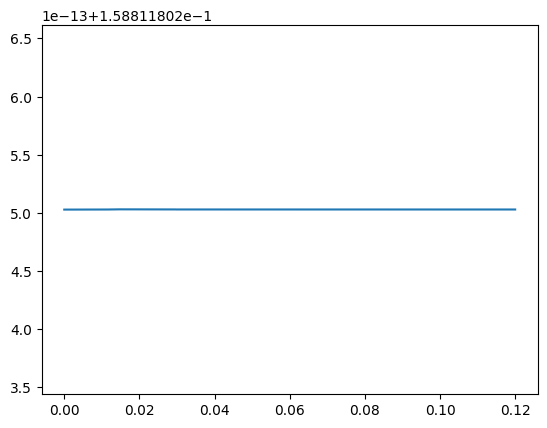

In [16]:
# dynamics equations
from matplotlib import pyplot as plt

# forward euler to plot some stuff
def euler(x0, dt, steps, dynamics_params):
    t = np.zeros(steps+1)
    x = np.zeros((len(x0),steps+1))
    x[:,0] = x0
    for i in range(1,steps+1):
        f = hsa_hopper.dynamics.evaluate(x[0,i-1],x[1,i-1],0,dynamics_params)
        x[0,i] = x[0,i-1] + dt*x[1,i-1] + (.5*dt**2)*f
        x[1,i] = x[1,i-1] + dt*f
        t[i] = t[i-1] + dt
    return x,t

x0 = np.array([theta1,thetadot1])
x,t = euler(x0,1e-4,int(1e4*tf),dynamics_params)
plt.plot(t,np.array([y(_x) for _x in x[0,:]]))
print(np.max([y(_x) for _x in x[0,:]]))

In [17]:
# import math
import hsa_hopper.collocation
collo_params = hsa_hopper.collocation.CollocationParameters(1,4,4,0,tf)
u = np.zeros(x.shape[1])
x_interp, u_interp = hsa_hopper.collocation.fit_interpolation(x[0,:],u,t,collo_params)

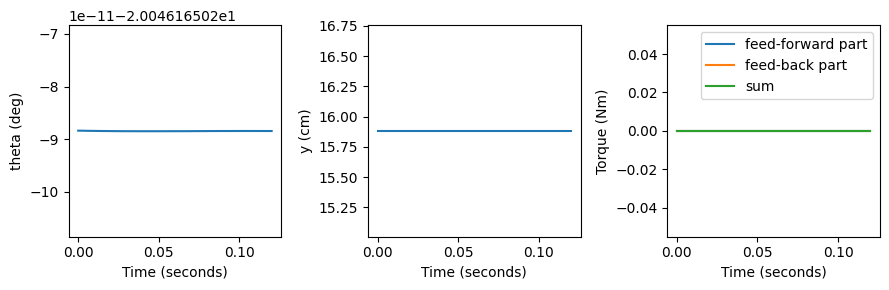

In [18]:
# visualise this interpolation
def make_interp_figure(x_interp, u_interp, dynamics_params):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(9,3))

    tk = x_interp.tk
    t_mat= np.vstack([np.linspace(tk[i], tk[i+1],100) for i in range(x_interp.M)])

    # compute interpolations
    x_data = np.hstack([[ x_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(x_interp.M)])
    y_data= y(x_data)
    u_data= np.hstack([[ u_interp.evaluate(_t) for _t in t_mat[i,:]] for i in range(u_interp.M)])
    t = t_mat.flatten()

    # make figures
    ax[0].plot(t, 180/np.pi*x_data)
    ax[1].plot(t, 100*y_data)
    ax[2].plot(t, u_data, label='feed-forward part')
    ax[2].plot(t, dynamics_params.Kx*(dynamics_params.x0-x_data), label='feed-back part')
    ax[2].plot(t, u_data+dynamics_params.Kx*(dynamics_params.x0-x_data), label='sum')

    ax[0].set_xlabel('Time (seconds)')
    ax[1].set_xlabel('Time (seconds)')
    ax[2].set_xlabel('Time (seconds)')

    ax[0].set_ylabel('theta (deg)')
    ax[1].set_ylabel('y (cm)')
    ax[2].set_ylabel('Torque (Nm)')
    ax[2].legend()
    fig.tight_layout()
    
make_interp_figure(x_interp,u_interp,dynamics_params)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6898963373916551
       x: [-2.236e-01  9.153e-02 -1.957e-01 -1.609e-01 -2.605e-01
           -4.101e+00 -2.134e+00 -1.768e-01]
     nit: 3
     jac: [ 0.000e+00 -1.944e+00 -5.609e+00 -3.082e+00 -2.124e-01
           -3.670e-01 -1.710e-01 -2.205e-01]
    nfev: 3
    njev: 3


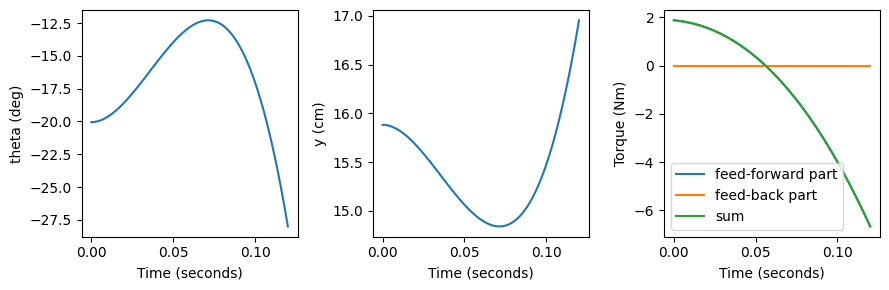

In [19]:
# finally apply dynamics constraints
# z = result.x
import yaml
from scipy.optimize import minimize
z = np.hstack([x_interp.mat.flatten(),u_interp.mat.flatten()])
bvp = hsa_hopper.collocation.HopBVP(
    [theta1,thetadot1],
    [thetaN,thetadotN],
    [-45*np.pi/180,-10],
    [45*np.pi/180,10],
    dynamics_params,
    collo_params
)
result = bvp.optimize(z, options = {
    'ftol': 1e-2,
    'maxiter': 20,
    'eps': 1e-6
})
print(result)

x_interp = hsa_hopper.collocation.PiecewiseInterpolation(bvp.c_mat,collo_params.tk)
u_interp = hsa_hopper.collocation.PiecewiseInterpolation(bvp.d_mat,collo_params.tk)
make_interp_figure(x_interp, u_interp,dynamics_params)
# plt.savefig('foo.png')

In [20]:
stance_controller = {
    'u_interp': u_interp.attribute_dict(),
    'initial_conditions': [theta1,thetadot1],
    'final_conditions': [thetaN,thetadotN],
    'Kx' : dynamics_params.Kx,
    'x0': dynamics_params.x0,
    'x_lo': theta_lo,
    'xdot_lo': thetadotN,
    'psi': dynamics_params.psi,
}
potential_string = ''
if dynamics_params.hsa_potential is None:
    potential_string = 'no_hsa'
    stance_controller['potential'] = None
else:
    potential_string = 'hsa'
    stance_controller['potential'] = dynamics_params.hsa_potential.attribute_dict()
    
with open(f'{potential_string}_startup_controller_{int(1000*dynamics_params.m)}g.yaml','w') as f:
    yaml.dump(stance_controller, f, yaml.Dumper)

In [21]:
# bvp.dynamic_constraints(bvp.result.x)